# Pytorch WeatherBench
Based on: https://github.com/pangeo-data/WeatherBench/blob/master/src/train_nn.py


In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

import os
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.data import WeatherBenchDataset2d
from modules.utils import load_test_data
from modules.models import CNN2dPeriodic
from modules.test import create_predictions_2D, compute_weighted_rmse

In [2]:
def train_model(model, device, train_generator, epochs, lr, validation_data, patience):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    min_val_loss = 1e15
    wait = 0
    stopped_epoch = 0
    stop_training = False
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            batch_size = batch.shape[0]
            
            # Model
            output = model(batch)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            for batch, labels in validation_data:
                # Transfer to GPU
                batch, labels = batch.to(device), labels.to(device)
                
                batch_size = batch.shape[0]
                
                output = model(batch)

                val_loss = val_loss + criterion(output, labels).item() * batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
                
            
        if (val_loss - min_val_loss) < 0:
            min_val_loss = val_loss
            wait = 0
        else:
            if wait >= patience:
                stopped_epoch = epoch + 1
                stop_training = True
            wait += 1
        
        if stop_training:
            print('Epoch {e:3d}: early stopping'.format(e=stopped_epoch))
            return train_losses, val_losses
        
    return train_losses, val_losses

In [3]:
#datadir = "../../data/5.625deg/"
datadir = "../data/equiangular/5.625deg/"

lr=1e-4
activation='elu'
dr=0
batch_size=128
patience=3
train_years=('1979', '2015')
valid_years=('2016', '2016')
test_years=('2017', '2018')
gpu=1
iterative=False

vars = ['z', 't']
kernel_size = 5

## 3 day prediction

In [4]:
training_weatherbench = np.load('../data/weatherbench_training.npy')
train_loss_w = training_weatherbench[0]
val_loss_w = training_weatherbench[1]
            
model_save_fn = "../data/predictions/models/torch_fccnn_3d.h5"
pred_save_fn = "../data/predictions/torch_fccnn_3d.nc"
lead_time = 72

# Test data
valid = load_test_data(f'{datadir}', lead_time)

In [5]:
# create directory if it doesn't exists already
if not os.path.isdir('/'.join(model_save_fn.split('/')[:-1])):
    if not os.path.isdir('/'.join(model_save_fn.split('/')[:-2])):
        os.mkdir('/'.join(model_save_fn.split('/')[:-2]))
    os.mkdir('/'.join(model_save_fn.split('/')[:-1]))
    
if not os.path.isdir('/'.join(pred_save_fn.split('/')[:-1])):
    os.mkdir('/'.join(pred_save_fn.split('/')[:-1]))

In [6]:
# 1. Open dataset and create data generators
z = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc', combine='by_coords')
t = xr.open_mfdataset(f'{datadir}temperature_850/*.nc', combine='by_coords')
ds = xr.merge([z, t], compat='override')  # Override level. discarded later anyway.

ds_train = ds.sel(time=slice(*train_years))
ds_valid = ds.sel(time=slice(*valid_years))
ds_test = ds.sel(time=slice(*test_years))

dic = {var: None for var in vars}

dataset_train = WeatherBenchDataset2d(ds_train, dic, lead_time)
dataset_valid = WeatherBenchDataset2d(ds_valid, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)
dataset_test = WeatherBenchDataset2d(ds_test, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)

dg_train_torch = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
dg_valid_torch = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=1)
dg_test_torch = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

# Build model and put on GPU
model_torch = CNN2dPeriodic(in_channels=2, out_channels=2, kernel_size=5)
device = torch.device("cuda:{}".format(0))
model_torch = model_torch.to(device)

# Train model
train_loss, val_loss = train_model(model_torch, device, dg_train_torch, epochs=100, lr=lr, 
                                   validation_data=dg_valid_torch, patience=patience)

print(f'Saving model weights: {model_save_fn}')
torch.save(model_torch.state_dict(), model_save_fn)

Loading data into RAM
Loading data into RAM
Loading data into RAM
Epoch:   1/100  - loss: 0.522  - val_loss: 0.48240  - time: 402.870291
Epoch:   2/100  - loss: 0.465  - val_loss: 0.45855  - time: 404.686392
Epoch:   3/100  - loss: 0.448  - val_loss: 0.45019  - time: 406.377110
Epoch:   4/100  - loss: 0.437  - val_loss: 0.44554  - time: 402.737463
Epoch:   5/100  - loss: 0.429  - val_loss: 0.44311  - time: 403.745329
Epoch:   6/100  - loss: 0.423  - val_loss: 0.42962  - time: 403.943428
Epoch:   7/100  - loss: 0.418  - val_loss: 0.42377  - time: 402.804462
Epoch:   8/100  - loss: 0.414  - val_loss: 0.42067  - time: 403.542800
Epoch:   9/100  - loss: 0.411  - val_loss: 0.42108  - time: 403.383224
Epoch:  10/100  - loss: 0.407  - val_loss: 0.41234  - time: 403.980064
Epoch:  11/100  - loss: 0.405  - val_loss: 0.41270  - time: 404.072581
Epoch:  12/100  - loss: 0.402  - val_loss: 0.41071  - time: 403.792848
Epoch:  13/100  - loss: 0.399  - val_loss: 0.40815  - time: 403.774818
Epoch:  14/

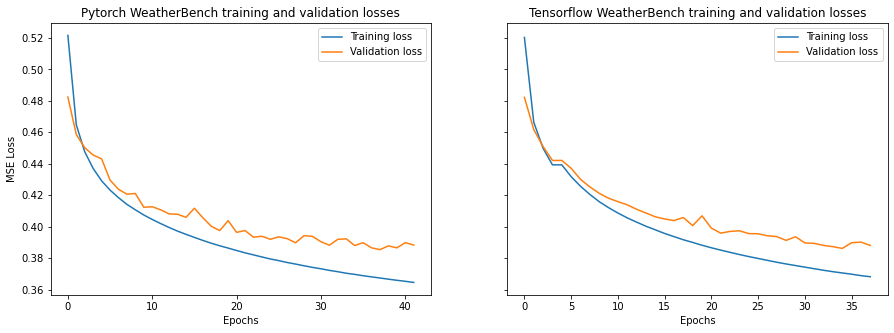

In [7]:
f, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)

axs[0].plot(train_loss, label='Training loss')
axs[0].plot(val_loss, label='Validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE Loss')
axs[0].legend()
axs[0].set_title("Pytorch WeatherBench training and validation losses")


axs[1].plot(train_loss_w, label='Training loss')
axs[1].plot(val_loss_w, label='Validation loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()
axs[1].set_title("Tensorflow WeatherBench training and validation losses")
plt.show()

In [8]:
# Create predictions
pred_torch = create_predictions_2D(model_torch, dg_test_torch, mean=dataset_train.mean, std=dataset_train.std, device=device)

# Print score in real units
print(compute_weighted_rmse(pred_torch, valid).load())

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 628.6
    t        float64 2.888


In [9]:
pred_torch

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17448)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, lat, lon) float32 50953.766 50936.492 ... 49520.387
    t        (time, lat, lon) float32 257.42227 257.71976 ... 252.60103 252.4306

In [11]:
pred_torch.to_netcdf('../data/predictions/' + "pred_torch.nc")